# 1 import Libraries


In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from fredapi import Fred
from tabulate import tabulate
import matplotlib.pyplot as plt
from financetoolkit import Toolkit
import json
from urllib.request import urlopen
import certifi
import scipy.stats as stats

# 2. Preprocessing Data

 ### 2.1 Initiate Variables
 
 Initiate the tickers, start_time, end_time etc for future usage 

In [21]:
tickers = "GDDY"
start_date = datetime(2020,1,1).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

results = []
closing_prices_df = []
economic_indicators = {
    'PCU332510332510' : 'Producer Price Index: Hardware',
    'PCU5182105182104' : 'Producer Price Index: Data management, information transformation, and related services',
    'PCU518210518210' : 'Producer Price Index: Electronic Computers',
    'PCU5182105182105' : 'Producer Price Index: Hosting, ASP, and other IT infrastructure provisioning services'
}

"""
CUUR0000SAE21 : Information and information processing
CUUR0000SEEE : Information technology, hardware and services
CUUR0000SEEE03 : Internet services and electronic information providers
"""
economic_indicators_CPI = ["SEEE", "SEEEC", "SAE21"]



In [5]:
fetch_stock_data = yf.download(tickers, start=start_date, end=end_date)
print(fetch_stock_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   68.790001   68.980003   67.220001   68.559998   68.559998   
2020-01-03   67.489998   69.410004   67.269997   68.760002   68.760002   
2020-01-06   68.160004   69.320000   67.980003   69.320000   69.320000   
2020-01-07   69.629997   69.959999   69.010002   69.029999   69.029999   
2020-01-08   69.190002   69.849998   68.900002   69.580002   69.580002   
...                ...         ...         ...         ...         ...   
2024-05-14  133.509995  133.979996  131.839996  132.820007  132.820007   
2024-05-15  133.660004  136.759995  133.660004  136.449997  136.449997   
2024-05-16  136.460007  136.899994  134.869995  135.009995  135.009995   
2024-05-17  135.399994  136.000000  134.625000  135.699997  135.699997   
2024-05-20  136.250000  137.990005  135.029999  137.960007  137.960007   

             Volume  
Date           

In [7]:
def fetch_fundamental_data(ticker):
    fundamental_data = {}
    stock_info = yf.Ticker(ticker)
    try:
        pe_ratio = stock_info.info['trailingPE']
    except KeyError:
        pe_ratio = None 

    try:
        beta = stock_info.info['beta']
    except KeyError:
        beta = None 

    try:
        pb_ratio = stock_info.info['priceToBook']
    except KeyError:
        pb_ratio = None 

    fundamental_data['pe_ratio'] = pe_ratio 
    fundamental_data['beta'] = beta
    fundamental_data['pb_ratio'] = pb_ratio


    return fundamental_data, 

f_data = fetch_fundamental_data('GDDY')

print(f_data)

({'pe_ratio': 11.96124, 'beta': 1.086, 'pb_ratio': 47.688873},)


 ### 2.2 Economic Data
 Using financial tool kit to get fundamental data, which an open-source toolkit in which all relevant financial ratios (150+), indicators and performance measurements are written down in the most simplistic way allowing for complete transparency of the method of calculation

Source: https://github.com/JerBouma/FinanceToolkit/tree/main

In [25]:
def fech_economic_data(economic_indicators, start_date, end_date):
    API_KEY = "69fd7790faf0151554331d3354cd8ab4"
    fred_client = Fred(api_key = API_KEY)
    ticker_data = {}
    for series_id, series_name in economic_indicators.items():
        try:
            data = fred_client.get_series(series_id, start_date = start_date, end_date = end_date)
            ticker_data[series_name] = data
        except Exception as e:
            print(f"Here is the error found for {series_name} : {e}")
    
    ticker_df = pd.DataFrame(ticker_data)
    return ticker_df

economic_data = fech_economic_data(economic_indicators, start_date, end_date)

economic_data
        

,Producer Price Index: Hardware,"Producer Price Index: Data management, information transformation, and related services",Producer Price Index: Electronic Computers,"Producer Price Index: Hosting, ASP, and other IT infrastructure provisioning services"
1985-06-01,100.000,NaN,NaN,NaN
1985-07-01,100.000,NaN,NaN,NaN
1985-08-01,100.200,NaN,NaN,NaN
1985-09-01,100.200,NaN,NaN,NaN
1985-10-01,100.300,NaN,NaN,NaN
...,...,...,...,...
2023-12-01,270.152,105.641,119.029,114.998
2024-01-01,268.535,105.686,119.403,115.742
2024-02-01,271.322,105.686,119.519,115.978
2024-03-01,269.260,105.686,119.251,115.433


In [26]:
df = pd.read_csv("cpi_data_2020_2024.csv")
# Filter for the required economic indicators
economic_indicators_CPI = ["SEEE", "SEEEC", "SAE21"]
filtered_df = df[df['Series_ID'].str.contains('|'.join(economic_indicators_CPI))]

# Pivot the DataFrame to get the desired format
pivot_df = filtered_df.pivot(index='Date', columns='Item_name', values='CPI_value')


pivot_df
print(pivot_df.columns)

Index(['Computer software and accessories',
       'Computers, peripherals, and smart home assistants',
       'Information and information processing',
       'Information technology commodities',
       'Information technology, hardware and services',
       'Internet services and electronic information providers',
       'Telephone hardware, calculators, and other consumer information items'],
      dtype='object', name='Item_name')


 ### 2.3 Income Statement Data
 Using financial tool kit to get fundamental data, which an open-source toolkit in which all relevant financial ratios (150+), indicators and performance measurements are written down in the most simplistic way allowing for complete transparency of the method of calculation

 Here is the income statement list:  
 
      Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')

Source: https://github.com/JerBouma/FinanceToolkit/tree/main

In [9]:
"""
Used 3rd party toolkit called {Finance Toolkit} 
to fetch Corporate Filling Data for a certain ticker 
"""


def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

def get_income_statement(symbol, period="annual", limit=100, api_key="YOUR_API_KEY"):
    url = (
        f"https://financialmodelingprep.com/api/v3/income-statement/{symbol}"
        f"?period={period}&limit={limit}&apikey={api_key}"
    )
    jsonparsed_data = get_jsonparsed_data(url)
    df = pd.DataFrame(jsonparsed_data)
    return df

# Example usage to fetch the data of "GDDY" ticker 
api_key = "NzNp1SUjBoFIw5BrIRmvTJQx174unV8I"
symbol = "GDDY"
period = "quarter"  # or "annual"
limit = 1000

income_statement = get_income_statement(symbol, period, limit, api_key)
print("Here is the income statement list: ", income_statement.columns)

income_statement.tail(5)

C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\461466069.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


Here is the income statement list:  Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')


,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,costOfRevenue,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
40,2014-03-31,GDDY,USD,0001609711,2014-03-31,2014-03-30 20:00:00,2014,Q1,320194000,125858000,...,-0.164179,-1226000,-51343000,-0.160350,-0.40,-0.40,128567000,128567000,,
41,2013-12-31,GDDY,USD,0001609711,2013-12-31,2013-12-30 19:00:00,2013,Q4,305929000,123059000,...,-0.221895,-2433000,-65451000,-0.213942,-0.51,-0.51,126118086,128567000,,
42,2013-09-30,GDDY,USD,0001609711,2013-09-30,2013-09-29 20:00:00,2013,Q3,286126000,119774000,...,-0.163250,618000,-47328000,-0.165410,-0.37,-0.37,126399790,128567000,,
43,2013-06-30,GDDY,USD,0001609711,2013-06-30,2013-06-29 20:00:00,2013,Q2,276018000,116498000,...,-0.126760,351000,-35339000,-0.128032,-0.27,-0.27,126243627,128567000,,
44,2013-03-31,GDDY,USD,0001609711,2013-03-31,2013-03-30 20:00:00,2013,Q1,262772000,114537000,...,-0.195774,322000,-51766000,-0.197000,-0.40,-0.40,123252380,128567000,,


 ### 2.4 Earning Calendars Data
 Using financial tool kit to get Calendar Data, here is an exmaple of result 

      Index(['date', 'symbol', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate', 'fiscalDateEnding'],
      dtype='object')

Source: https://github.com/JerBouma/FinanceToolkit/tree/main

In [10]:
"""
https://finance.yahoo.com/quote/GDDY/analysis EPS prediction chart 
"""
def get_earnings_calendar(symbol, limit=100, api_key="YOUR_API_KEY"):
    url = (
        f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{symbol}"
        f"?limit={limit}&apikey={api_key}"
    )
    json_data = get_jsonparsed_data(url)
    df = pd.DataFrame(json_data)
    return df

# Example usage
api_key = "NzNp1SUjBoFIw5BrIRmvTJQx174unV8I"
symbol = "GDDY"
limit = 100

earnings_calendar = get_earnings_calendar(symbol, limit, api_key)
earnings_calendar.head(7)

C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\461466069.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


,date,symbol,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,2025-04-30,GDDY,NaN,NaN,amc,NaN,NaN,2024-05-21,2025-03-31
1,2025-02-11,GDDY,NaN,NaN,amc,NaN,NaN,2024-05-21,2024-12-31
2,2024-10-31,GDDY,NaN,NaN,amc,NaN,NaN,2024-05-21,2024-09-30
3,2024-08-01,GDDY,NaN,1.07,amc,NaN,1.113800e+09,2024-05-21,2024-06-30
4,2024-05-02,GDDY,1.08,1.00,amc,1.106900e+09,1.096820e+09,2024-05-21,2024-03-31
5,2024-02-13,GDDY,1.08,1.03,amc,1.100300e+09,1.102100e+09,2024-04-18,2023-12-31
6,2023-11-02,GDDY,0.90,0.72,amc,1.069700e+09,1.065360e+09,2024-03-14,2023-09-30


# 3.Data EDA

Quick plot the daily close price data over the past five years to see a trend 

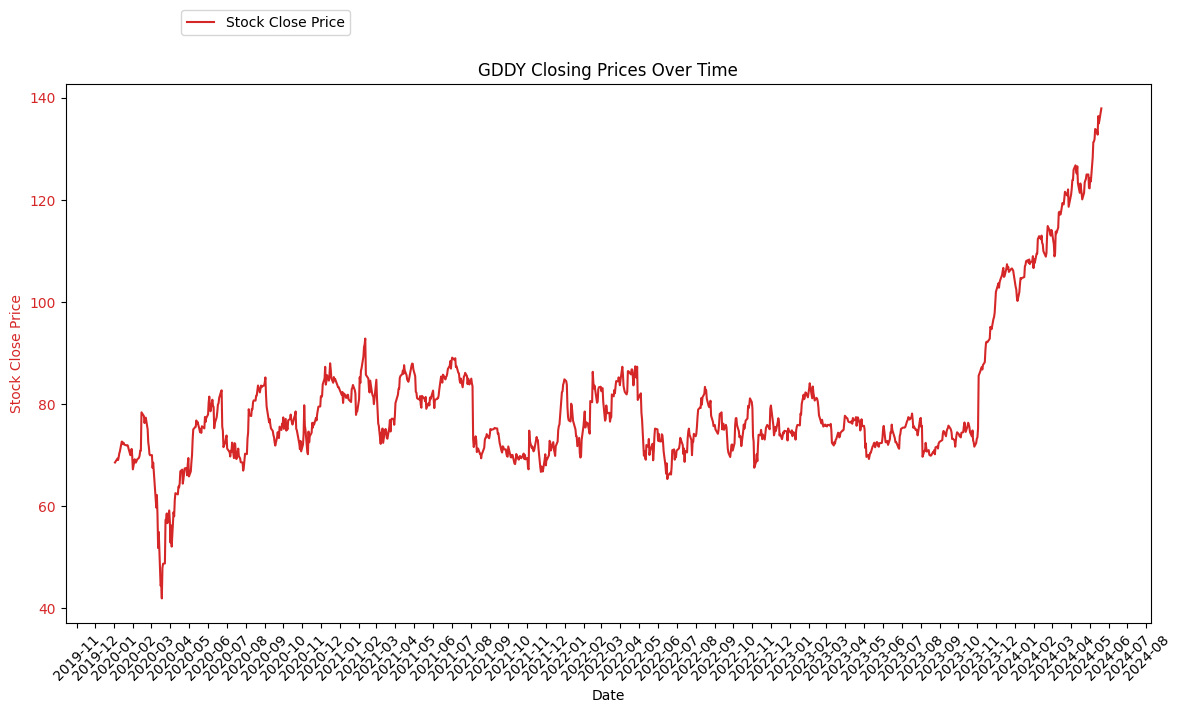

In [27]:
import matplotlib.dates as mdates
def plot_data_with_different_frequencies(stock_data,tickers):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting the stock closing prices
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Close Price', color='tab:red')
    ax1.plot(stock_data.index, stock_data['Close'], color='tab:red', label='Stock Close Price')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    

    
    # Set major x-ticks to monthly for better visibility
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Rotate date labels for better legibility
    plt.xticks(rotation=45)
    
    # Legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    
    ax1.legend(handles1, labels1, loc='upper left', bbox_to_anchor=(0.1, 1.15))
    
    plt.title(f'{tickers} Closing Prices Over Time')
    plt.show()

# plot Stock Daily Close Price 
plot_data_with_different_frequencies(fetch_stock_data,tickers)

In [28]:
# Re-Initialize the DataFrame 

# Example usage to fetch the data of "GDDY" ticker 
api_key = "NzNp1SUjBoFIw5BrIRmvTJQx174unV8I"
symbol = ["GDDY", "WIX"]
period = "quarter"  # or "annual"
limit = 1000


GDDY_income_statement = get_income_statement(symbol[0], period, limit, api_key)
WIX_income_statement = get_income_statement(symbol[1], period, limit, api_key)
GDDY_income_statement.head()
WIX_income_statement.head()

C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\461466069.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,costOfRevenue,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
0,2024-03-31,WIX,USD,0001576789,2024-05-20,2024-05-20 07:37:08,2024,Q1,419776000,137297000,...,0.068525,4763000,24002000,0.057178,0.4300,0.41,56098997,58647238,https://www.sec.gov/Archives/edgar/data/157678...,https://www.sec.gov/Archives/edgar/data/157678...
1,2023-12-31,WIX,USD,0001576789,2024-03-22,2024-03-22 06:13:14,2023,Q4,403771000,126113000,...,0.020492,5320000,2954000,0.007316,0.0515,0.05,57317815,59085757,https://www.sec.gov/Archives/edgar/data/157678...,https://www.sec.gov/Archives/edgar/data/157678...
2,2023-09-30,WIX,USD,0001576789,2023-11-09,2023-11-09 07:37:15,2023,Q3,393841000,129043000,...,0.021118,1342000,6975000,0.017710,0.1200,0.12,56837917,58497072,https://www.sec.gov/Archives/edgar/data/157678...,https://www.sec.gov/Archives/edgar/data/157678...
3,2023-06-30,WIX,USD,0001576789,2023-08-03,2023-08-03 07:59:15,2023,Q2,389977000,127894000,...,0.084997,-430000,33577000,0.086100,0.5900,0.54,56744007,62186895,https://www.sec.gov/Archives/edgar/data/157678...,https://www.sec.gov/Archives/edgar/data/157678...
4,2023-03-31,WIX,USD,0001576789,2023-05-17,2023-05-17 08:56:22,2023,Q1,374076000,129478000,...,-0.031809,-1530000,-10369000,-0.027719,-0.1800,-0.18,56408677,56408677,https://www.sec.gov/Archives/edgar/data/157678...,https://www.sec.gov/Archives/edgar/data/157678...


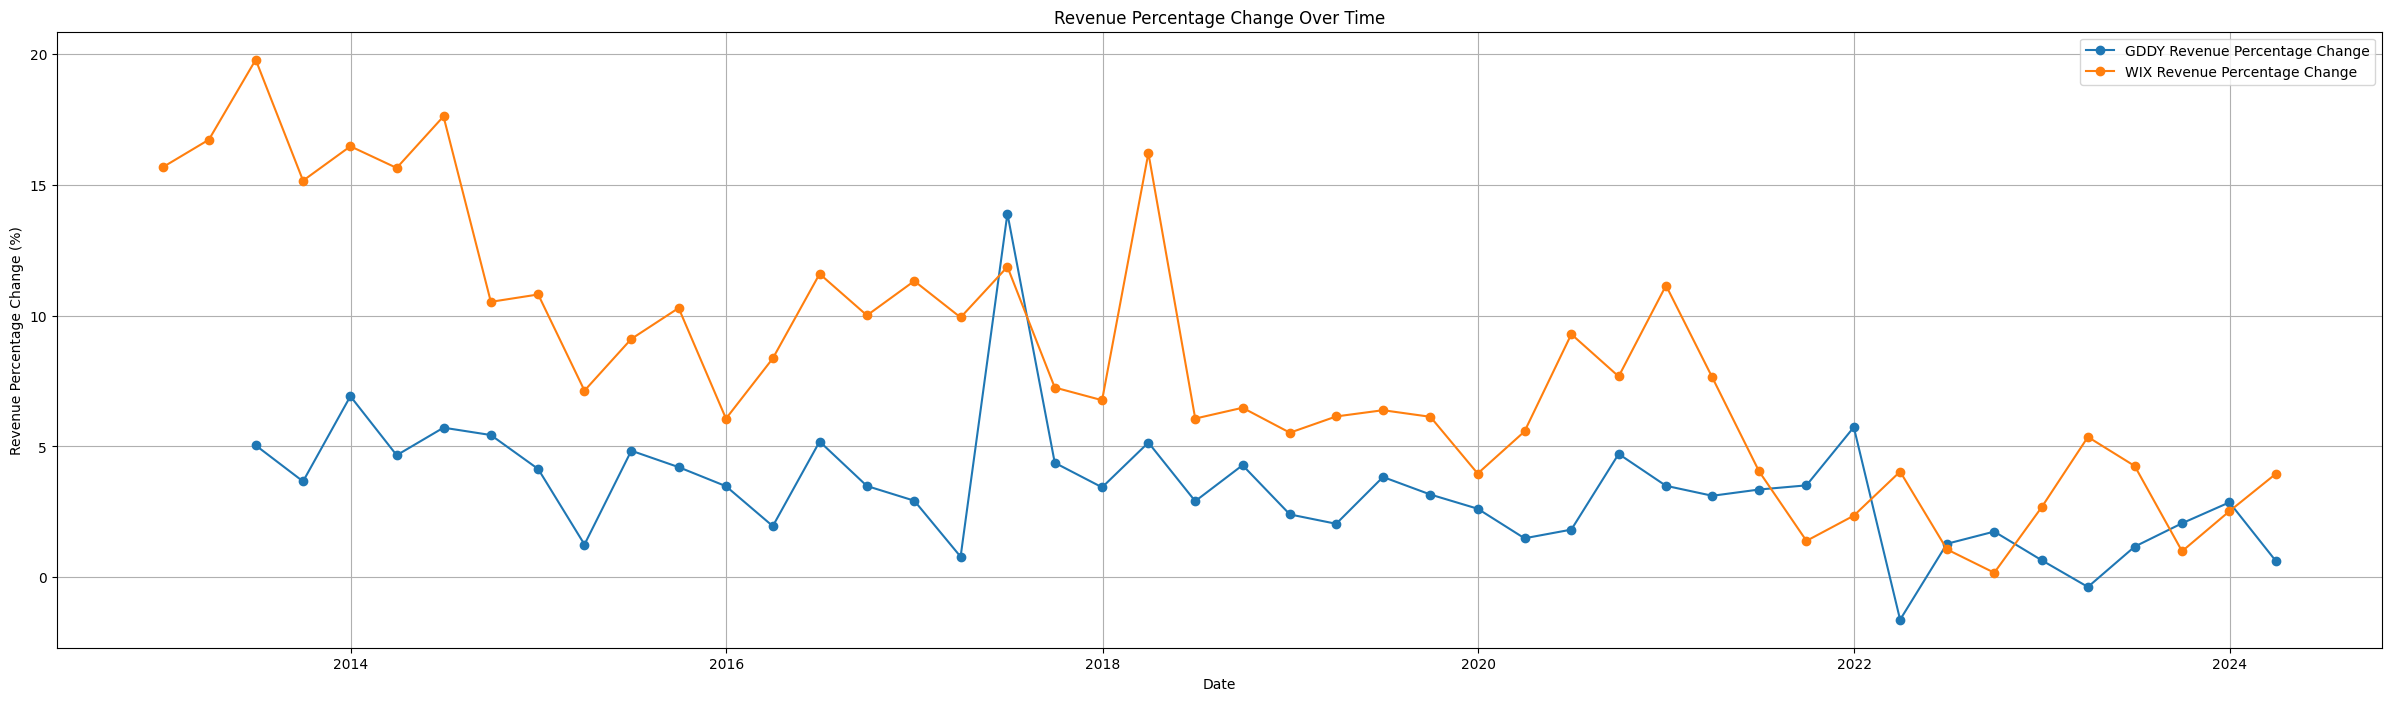

In [29]:
def plot_revenue_percentage_change(companies_income_statements, companies_symbols):
    plt.figure(figsize=(30, 8))

    for income_statement, symbol in zip(companies_income_statements, companies_symbols):
        # Convert 'date' column to datetime
        income_statement['date'] = pd.to_datetime(income_statement['date'])

        # Sort by date
        income_statement.sort_values('date', inplace=True)

        # Calculate revenue percentage change
        income_statement['revenue_pct_change'] = income_statement['revenue'].pct_change() * 100

        # Plot revenue percentage change
        plt.plot(income_statement['date'], income_statement['revenue_pct_change'], marker='o', linestyle='-', label=f'{symbol} Revenue Percentage Change')

    # Adding titles and labels
    plt.title('Revenue Percentage Change Over Time')
    plt.xlabel('Date')
    plt.ylabel('Revenue Percentage Change (%)')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

symbols = ["GDDY", "WIX"]
# Plot the percentage change
plot_revenue_percentage_change([GDDY_income_statement, WIX_income_statement], symbols)

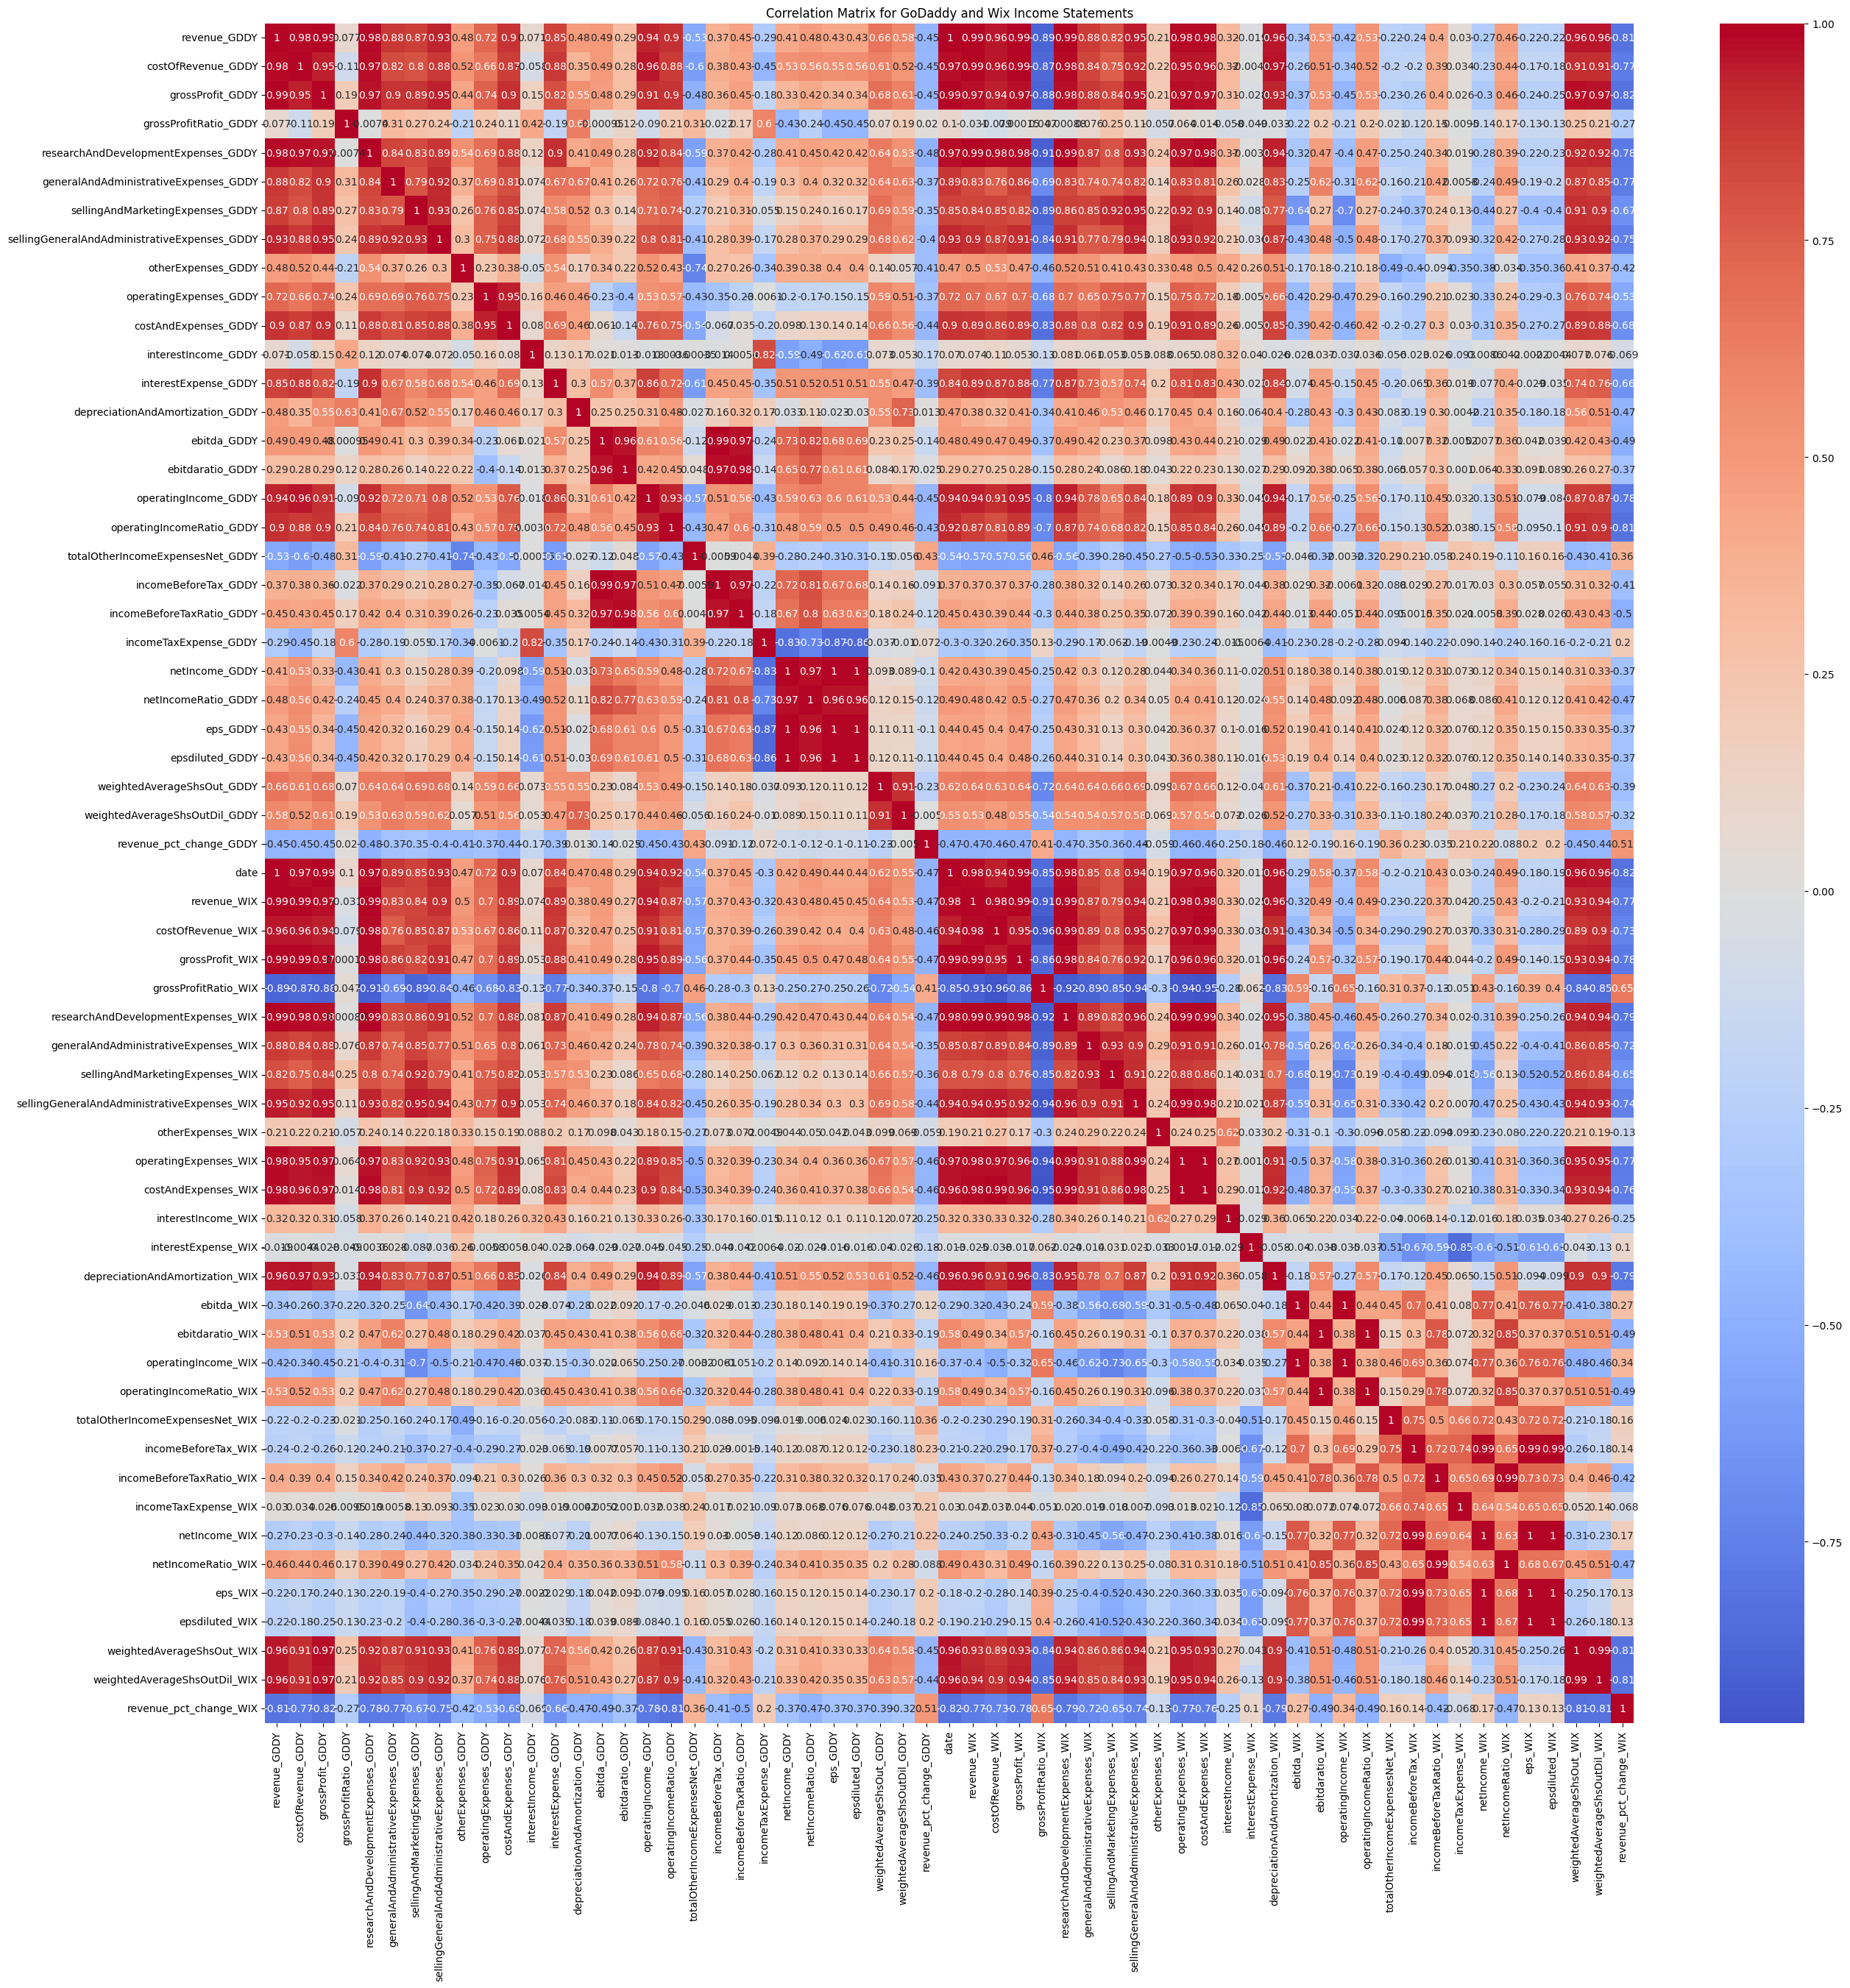

In [30]:
import seaborn as sns
def filter_numeric_columns(df):
    return df.select_dtypes(include=[float, int])

def plot_correlation_matrix(data, title):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

# Convert 'date' column to datetime
GDDY_income_statement['date'] = pd.to_datetime(GDDY_income_statement['date'])
WIX_income_statement['date'] = pd.to_datetime(WIX_income_statement['date'])
# Filter to include only numeric columns
GDDY_numeric = filter_numeric_columns(GDDY_income_statement)
WIX_numeric = filter_numeric_columns(WIX_income_statement)
# Ensure the 'date' column is included for merging
GDDY_numeric['date'] = GDDY_income_statement['date']
WIX_numeric['date'] = WIX_income_statement['date']
# Merge datasets on a common time index
merged_data = pd.merge(GDDY_numeric, WIX_numeric, on='date', suffixes=('_GDDY', '_WIX'))

# Plot the correlation matrix
plot_correlation_matrix(merged_data, 'Correlation Matrix for GoDaddy and Wix Income Statements')

In [31]:
def find_highly_correlated_pairs(corr_matrix, threshold=0.7):
    corr_pairs = corr_matrix.unstack()
    high_corr_pairs = corr_pairs[(abs(corr_pairs) > threshold) & (abs(corr_pairs) < 1)]
    high_corr_pairs = high_corr_pairs.drop_duplicates().sort_values(ascending=False)
    return high_corr_pairs

def determine_statistical_significance(data, high_corr_pairs):
    significant_pairs = []
    for pair, corr_value in high_corr_pairs.items():
        x = data[pair[0]]
        y = data[pair[1]]
        corr, p_value = stats.pearsonr(x, y)
        if p_value < 0.05:
            significant_pairs.append((pair, corr_value, p_value))
    return significant_pairs



# Convert 'date' column to datetime
GDDY_income_statement['date'] = pd.to_datetime(GDDY_income_statement['date'])
WIX_income_statement['date'] = pd.to_datetime(WIX_income_statement['date'])

# Filter to include only numeric columns
GDDY_numeric = filter_numeric_columns(GDDY_income_statement)
WIX_numeric = filter_numeric_columns(WIX_income_statement)

# Ensure the 'date' column is included for merging
GDDY_numeric['date'] = GDDY_income_statement['date']
WIX_numeric['date'] = WIX_income_statement['date']

# Merge datasets on a common time index
# Drop the 'date' column for correlation analysis
# Calculate the correlation matrix
merged_data = pd.merge(GDDY_numeric, WIX_numeric, on='date', suffixes=('_GDDY', '_WIX'))
merged_data_no_date = merged_data.drop(columns=['date'])
correlation_matrix = merged_data_no_date.corr()

# Find highly correlated pairs
highly_correlated_pairs = find_highly_correlated_pairs(correlation_matrix)

# Filter for cross-company correlations
cross_company_pairs = [(pair, corr_value) for pair, corr_value in highly_correlated_pairs.items() if ('_GDDY' in pair[0] and '_WIX' in pair[1]) or ('_WIX' in pair[0] and '_GDDY' in pair[1])]

# Determine statistical significance for cross-company correlations
significant_cross_company_correlations = []
for pair, corr_value in cross_company_pairs:
    x = merged_data_no_date[pair[0]]
    y = merged_data_no_date[pair[1]]
    corr, p_value = stats.pearsonr(x, y)
    if p_value < 0.05:
        significant_cross_company_correlations.append((pair, corr_value, p_value))

# Print the significant cross-company correlations
print("Highly correlated and statistically significant cross-company pairs:")
for pair, corr_value, p_value in significant_cross_company_correlations:
    print(f"{pair[0]} and {pair[1]}: correlation = {corr_value}, p-value = {p_value}")

Highly correlated and statistically significant cross-company pairs:
researchAndDevelopmentExpenses_GDDY and revenue_WIX: correlation = 0.9913707139991406, p-value = 1.3851808151861789e-39
revenue_GDDY and grossProfit_WIX: correlation = 0.9910628924013273, p-value = 2.934049594234725e-39
revenue_GDDY and researchAndDevelopmentExpenses_WIX: correlation = 0.9907424100398541, p-value = 6.238339729615142e-39
revenue_GDDY and revenue_WIX: correlation = 0.9899157087221953, p-value = 3.8923043351596595e-38
researchAndDevelopmentExpenses_GDDY and researchAndDevelopmentExpenses_WIX: correlation = 0.9887770352696243, p-value = 3.839521394692927e-37
costOfRevenue_GDDY and grossProfit_WIX: correlation = 0.9873458750167105, p-value = 4.9984236457567126e-36
costOfRevenue_GDDY and revenue_WIX: correlation = 0.9870423170036843, p-value = 8.296246777190133e-36
researchAndDevelopmentExpenses_GDDY and grossProfit_WIX: correlation = 0.9810348236102866, p-value = 2.817566080357845e-32
costOfRevenue_GDDY an

Cross-Company Correlations:
-----------------------------------------------------------------------------
- Revenue and Gross Profit:

    revenue_GDDY and revenue_WIX (correlation: 0.9899): Indicates that revenue trends between the two companies are highly correlated, suggesting similar market or industry conditions affecting both.

    revenue_GDDY and grossProfit_WIX (correlation: 0.9911): Strong relationship between GoDaddy's revenue and Wix's gross profit.

- Research and Development:

    researchAndDevelopmentExpenses_GDDY and revenue_WIX (correlation: 0.9914): Suggests that GoDaddy's R&D spending is highly correlated with Wix's revenue, possibly indicating parallel investment in innovation.

### Econ and Fundamental Data Plot

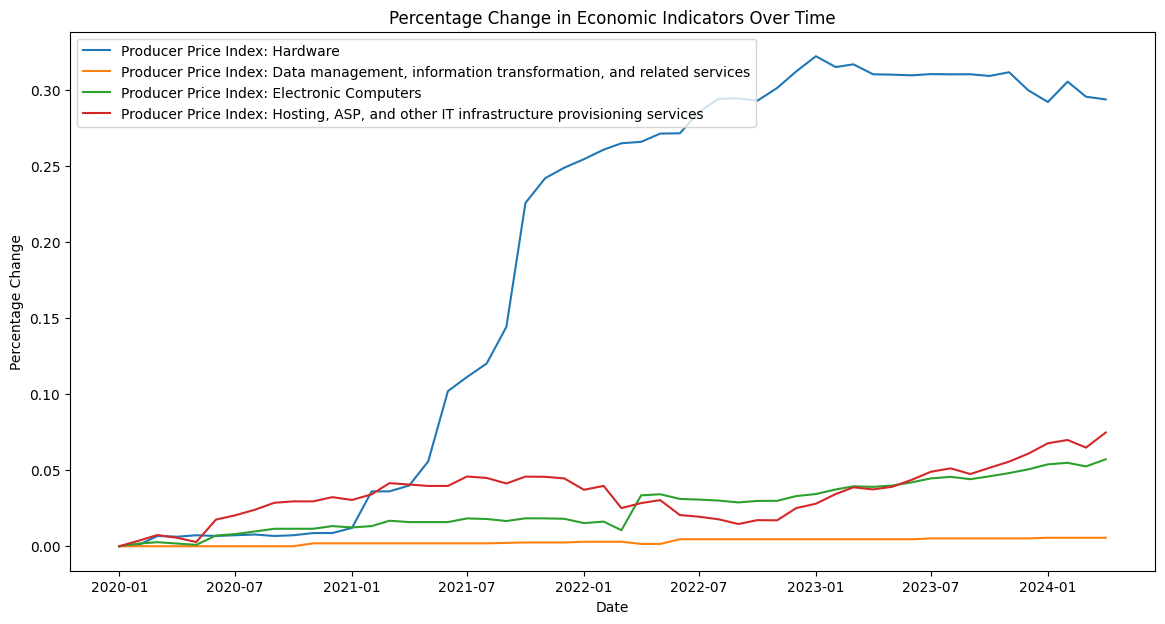

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_economic_data_percentage_change(economic_data):
    # Calculate percentage change from the first available data point
    econ_pct_change = economic_data.pct_change().fillna(0).add(1).cumprod().sub(1)

    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plotting economic indicators
    for column in econ_pct_change.columns:
        ax.plot(economic_data.index, econ_pct_change[column], label=column)

    ax.set_xlabel('Date')
    ax.set_ylabel('Percentage Change')
    ax.legend(loc='upper left')
    plt.title('Percentage Change in Economic Indicators Over Time')
    plt.show()

# Assuming economic_data is loaded and properly prepared
# plot_economic_data_percentage_change(filtered_economic_data)
economic_data.index = pd.to_datetime(economic_data.index)

# Filter the range from 2020 to 2024
filtered_economic_data = economic_data['2020-01-01':'2024-12-31']

plot_economic_data_percentage_change(filtered_economic_data)

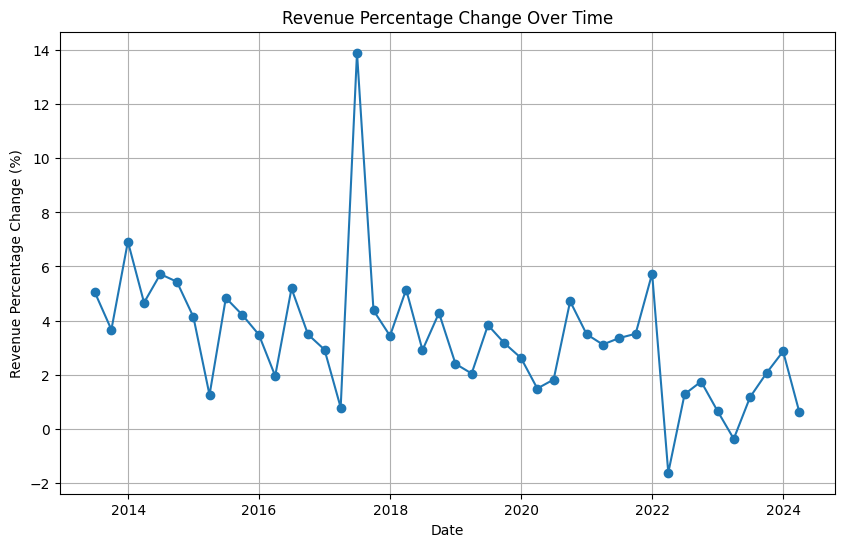

In [33]:
def plot_revenue_percentage_change(income_statement):
    # Convert the 'date' column to datetime format
    income_statement['date'] = pd.to_datetime(income_statement['date'])
    
    # Sort the DataFrame by date
    income_statement.sort_values('date', inplace=True)
    
    # Calculate the revenue percentage change
    income_statement['revenue_pct_change'] = income_statement['revenue'].pct_change() * 100
    
    # Plot the revenue percentage change
    plt.figure(figsize=(10, 6))
    plt.plot(income_statement['date'], income_statement['revenue_pct_change'], marker='o', linestyle='-')
    plt.title('Revenue Percentage Change Over Time')
    plt.xlabel('Date')
    plt.ylabel('Revenue Percentage Change (%)')
    plt.grid(True)
    plt.show()

plot_revenue_percentage_change(income_statement)

C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\1105400253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_statement['date'] = pd.to_datetime(income_statement['date'])
C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\1105400253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_statement.sort_values('date', inplace=True)
C:\Users\ahu\AppData\Local\Temp\ipykernel_24148\1105400253.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

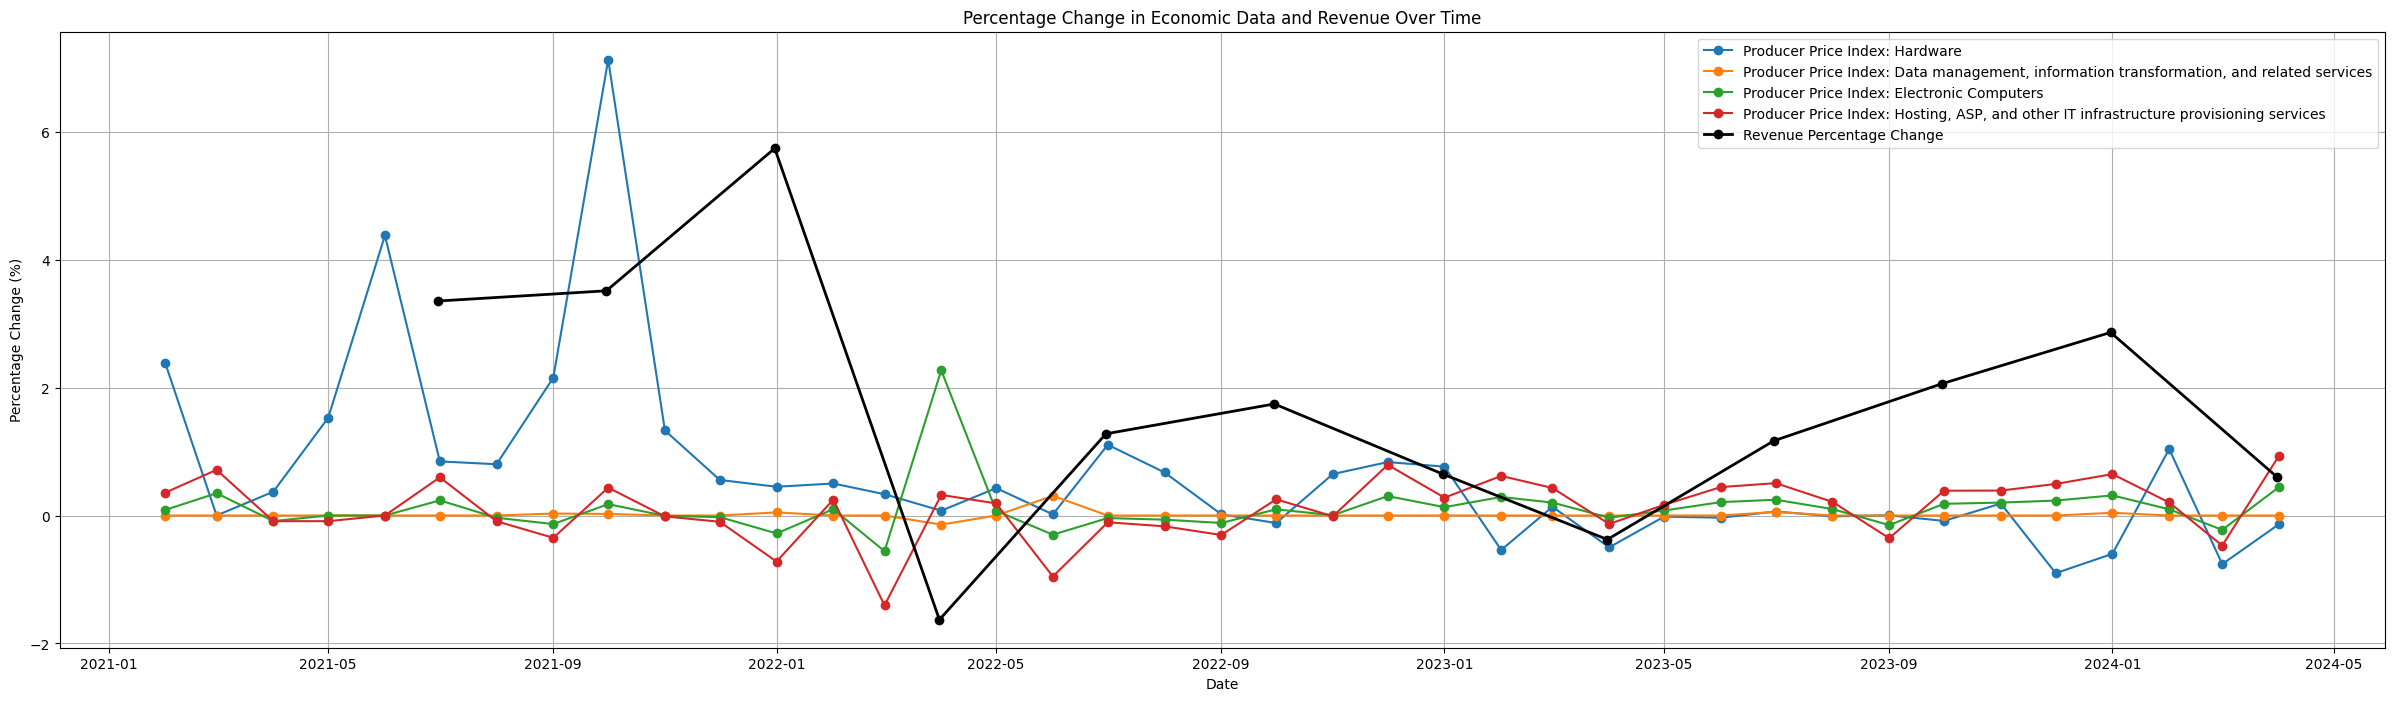

In [34]:
def plot_economic_and_revenue_percentage_change(economic_data, income_statement):
    # Convert 'date' column in income_statement to datetime if it's not already
    income_statement['date'] = pd.to_datetime(income_statement['date'])
    # Sort income_statement by date
    income_statement.sort_values('date', inplace=True)
    
    # Calculate revenue percentage change
    income_statement['revenue_pct_change'] = income_statement['revenue'].pct_change() * 100
    
    # Calculate percentage change for each economic data column
    economic_data_pct_change = economic_data.pct_change() * 100
    
    # Plotting
    plt.figure(figsize=(30, 8))
    
    # Plot economic data percentage changes
    for column in economic_data_pct_change.columns:
        plt.plot(economic_data_pct_change.index, economic_data_pct_change[column], marker='o', linestyle='-', label=column)
    
    # Plot revenue percentage change
    plt.plot(income_statement['date'], income_statement['revenue_pct_change'], marker='o', linestyle='-', label='Revenue Percentage Change', color='black', linewidth=2)
    
    # Adding titles and labels
    plt.title('Percentage Change in Economic Data and Revenue Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change (%)')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()


filtered_economic_data = economic_data[(economic_data.index >= '2021-01-01') & (economic_data.index <= '2024-12-31')]
filtered_income_statement = income_statement[(income_statement['date'] >= '2021-01-01') & (income_statement['date'] <= '2024-12-31')]
plot_economic_and_revenue_percentage_change(filtered_economic_data, filtered_income_statement)